# Bitcoin Quantitative Analysis
- To perform technical quantitative analysis for a given financial asset.
- To measure the risk return profile a given financial asset.
- To identify the pros and cons of a given financial asset within a total portfolio allocation.

Source(s): 
- Yahoo Finance

In [2]:
#######################################################
# Set Up                                              #   
#######################################################

import math
import os
import random
import re
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import requests
from functools import reduce

pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Helping functions

In [3]:
def format_column_names(df):
    """The functions returns a data frame with its formatted columns"""
    # Convert column names to lowercase
    df.rename(columns=str.lower, inplace=True)
    
    # Replace spaces with underscores
    df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
    
    # Replace hyphens with underscores
    df.rename(columns=lambda x: x.strip().replace("-", "_"), inplace=True)
    
    return df


In [4]:
def analyze_dataset(dataset):
    """
    Analyzes a given dataset and prints information about each column.

    Args:
        dataset (pd.DataFrame): The input dataset.

    Returns:
        None
    """
    print(type(dataset))
    # Get column names
    columns = dataset.columns

    # Print column information
    for col in columns:
        dtype = dataset[col].dtype
        num_nan = dataset[col].isna().sum()
        num_zeros = (dataset[col] == 0).sum()

        print(f"Column: {col}")
        print(f"  Data Type: {dtype}")
        print(f"  NaN Values: {num_nan}")
        print(f"  Zero Values: {num_zeros}\n")

In [17]:
def fetch_yf(tickers, start_date, end_date):
    """
    Fetches historical closing price data using Yahoo Finance API.

    Args:
        tickers (list of str): List of stock tickers.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pandas.DataFrame: A DataFrame containing adjusted closing prices for the specified tickers.
    """
    df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
    df.reset_index(inplace=True)
    df = format_column_names(df)
    df['date'] = pd.to_datetime(df['date'])
    return df


In [6]:
def winsorize_series(s, ci=0.05):
    """
    Winsorizes a pandas Series by replacing extreme values with the corresponding quantiles.

    Parameters:
        s (pd.Series): Input Series to be winsorized.
        ci (float, optional): Confidence interval for quantiles. Defaults to 0.05.

    Returns:
        pd.Series: Winsorized Series.
    """
    q = s.quantile([ci, 1 - ci])
    if isinstance(q, pd.Series) and len(q) == 2:
        s[s < q.iloc[0]] = q.iloc[0]
        s[s > q.iloc[1]] = q.iloc[1]
    return s


In [7]:
def winsorize_returns(s, ci=0.01):
    """
    Winsorizes the input returns series by replacing extreme values with the corresponding quantiles.

    Parameters:
        s (pd.Series): Input returns series.
        ci (float, optional): Winsorization level (default is 0.01).

    Returns:
        pd.DataFrame: Winsorized returns with the same columns and index as the input series.
    """
    q_low = s.quantile(ci)
    q_high = s.quantile(1 - ci)
    win_return = np.where(s < q_low, q_low, np.where(s > q_high, q_high, s))
    return pd.DataFrame(win_return, columns=s.columns, index=s.index)


## Project Functions

In [27]:
def relative_differences_daily(df, ema_fast, ema_slow, years=5):
    """
    Calculates and plots the relative differences between the latest price and moving averages.

    Args:
        df (pd.DataFrame): Input dataset with given columns required for the calculation.
        ema_fast (int): Span for calculating the fast exponential moving average (EMA).
        ema_slow (int): Span for calculating the slow EMA.
        years (int): Number of years of data to consider (for plotting).

    Returns:
        None (displays the statistics and plot)
    """
    # set date as index 
    tmp = df.set_index('date')
    tmp = tmp.dropna()

    # Calculate faste and slow exponential moving average (EMA)
    ema_fast = tmp.ewm(span=ema_fast, adjust=False).mean()
    ema_slow = tmp.ewm(span=ema_slow, adjust=False).mean()

    # Calculate relative differences to EMAs
    diff_ema_fast = (tmp - ema_fast) / ema_fast * 100
    diff_ema_slow = (tmp - ema_slow) / ema_slow * 100

    # statistics
    last_price = np.array(tmp)[-1].item()
    last_diff_ema_fast_value = np.array(diff_ema_fast)[-1].item()
    last_diff_ema_slow_value = np.array(diff_ema_slow)[-1].item()
    last_ema_fast_value = np.array(ema_fast)[-1].item()
    last_ema_slow_value = np.array(ema_slow)[-1].item()

    # print statistics
    print(f"Last Close price: {last_price:.2f} is {last_diff_ema_fast_value:.2f}% relative to the fast ema and {last_diff_ema_slow_value:.2f}% relative to the slow ema")
    print(f"Last EMA Fast value (average): {last_ema_fast_value:.2f}")
    print(f"Last EMA Slow value (average): {last_ema_slow_value:.2f}")

    # Plot the relative differences
    plt.figure(figsize=(10, 6))
    plt.plot(diff_ema_fast[-365*years:], label='Relative Diff (EMA Fast)')
    plt.plot(diff_ema_slow[-365*years:], label='Relative Diff (EMA Slow)')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Relative Difference (%)')
    plt.title('Relative Differences: Close vs. Moving Averages')
    plt.legend()
    plt.grid(False)
    plt.show()

In [9]:
def relative_differences_monthly(df, ema_fast, ema_slow):
    """
    Plots the relative differences between the latest price and moving averages.

    Args:
        df (pd.DataFrame): Input dataset with 'Close' column.

    Returns:
        None (displays the plot)
    """
    
    #df.set_index('Date', inplace=True)
    tmp = df.copy()
    tmp_resampled = tmp.set_index('date').resample('M').last()

    # Calculate fast and slow exponential moving average (EMA)
    ema_fast = tmp_resampled.ewm(span=ema_fast, adjust=False).mean()
    ema_slow = tmp_resampled.ewm(span=ema_slow, adjust=False).mean()

    # Calculate relative differences
    diff_ema_fast = (tmp_resampled - ema_fast) / ema_fast * 100
    diff_ema_slow = (tmp_resampled - ema_slow) / ema_slow * 100

    # statistics
    last_price = np.array(tmp_resampled)[-1].item()
    last_diff_ema_fast_value = np.array(diff_ema_fast)[-1].item()
    last_diff_ema_slow_value = np.array(diff_ema_slow)[-1].item()
    last_ema_fast_value = np.array(ema_fast)[-1].item()
    last_ema_slow_value = np.array(ema_slow)[-1].item()

    # print statistics
    print(f"Last Close price: {last_price:.2f} is {last_diff_ema_fast_value:.2f}% relative to the fast ema and {last_diff_ema_slow_value:.2f}% relative to the slow ema")
    print(f"Last EMA Fast value (average): {last_ema_fast_value:.2f}")
    print(f"Last EMA Slow value (average): {last_ema_slow_value:.2f}")

    # Plot the relative differences
    plt.figure(figsize=(10, 6))
    plt.plot(diff_ema_fast, label='Relative Diff (EMA fast)')
    plt.plot(diff_ema_slow, label='Relative Diff (EMA slow)')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Relative Difference (%)')
    plt.title('Relative Differences: Close vs. Moving Averages')
    plt.legend()
    plt.grid(False)
    plt.show()

In [10]:
def plot_rolling_annualized_return(df, years, last_n_observations):
    
    # set date as index 
    tmp = df.set_index('date')

    # Calculate the rolling annualized return for a 3-year window
    tmp = tmp.dropna()
    log_returns = np.log(tmp / tmp.shift(1))
    rolling_annualized_return = log_returns.rolling(window=years * 365).mean() * 365 * 100

    # winsorization --- if needed
    #winsorized_returns = winsorize_returns(log_returns)
    #rolling_annualized_return = winsorized_returns.rolling(window=years * 365).mean() * 365 * 100

    # statistics
    last_rolling_annualized_return = np.array(rolling_annualized_return)[-1].item()
    
    # print statistics
    print(f"Last rolling annualized return: {last_rolling_annualized_return:.2f}%")

    # Plot the rolling annualized return
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_annualized_return.iloc[-last_n_observations*365:], label='Rolling 3y Avg Return')
    plt.title(f'{years}-Year Rolling Annualized Return (Last {last_n_observations} years)')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
def plot_rolling_annualized_volatility(df, years, last_n_observations):
    # set date as index 
    tmp = df.set_index('date')

    # Calculate the rolling annualized volatility for a 3-year window
    tmp = tmp.dropna()
    log_returns = np.log(tmp / tmp.shift(1))
    #rolling_annualized_volatility = winsorize_series(log_returns).rolling(window=years * 365).std() * (365 ** 0.5) * 100

    # winsorization
    winsorized_returns = winsorize_returns(log_returns)
    rolling_annualized_volatility = winsorized_returns.rolling(window=years * 365).std() * (365 ** 0.5) * 100
    
    # statistics
    last_rolling_annualized_volatility = np.array(rolling_annualized_volatility)[-1].item()

    # print statistics
    print(f"Last rolling annualized volatility: {last_rolling_annualized_volatility:.2f}%")
    
    # Plot the rolling annualized return
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_annualized_volatility.iloc[-last_n_observations*365:], label='3y Rolling Volatility')
    plt.title(f'{years}-Year Rolling Annualized Volatility (Last {last_n_observations} years)')
    plt.axhline(y=55, color='gray', linestyle='--', linewidth=1)
    plt.title('x-Year Rolling Annualized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def plot_rolling_annualized_sharpe(df, years, last_n_observations):
    # set date as index 
    tmp = df.set_index('date')

    # Calculate the rolling annualized sharpe ratio for a 3-year window
    tmp = tmp.dropna()
    log_returns = np.log(tmp / tmp.shift(1))
    
    # winsorization
    winsorized_returns = winsorize_returns(log_returns)

    rolling_annualized_sharpe = ((winsorized_returns.rolling(window=years * 365).mean() * 365) 
    / (winsorized_returns.rolling(window=years * 365).std() * (365 ** 0.5)))

    # statistics
    last_rolling_sharpe = np.array(rolling_annualized_sharpe)[-1].item()
    
    # print statistics
    print(f"Last rolling annualized sharpe: {last_rolling_sharpe:.2f}")

    # Plot the rolling annualized return
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_annualized_sharpe.iloc[-last_n_observations*365:], label='3y Rolling Sharpe')
    plt.title(f'{years}-Year Rolling Annualized Sharpe (Last {last_n_observations} years)')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.title('x-Year Rolling Annualized Sharpe')
    plt.xlabel('Date')
    plt.ylabel('Sharpe')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def drawdown(df):
    """
    Take a time series of the asset returns
    Computes the returns and draws a plot of the drawdowns
    """
    # set date as index 
    tmp = df.set_index('date')
    tmp = tmp.dropna()
    return_series = tmp.pct_change()
    wealth_index = 1000 * (1 + return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = ((wealth_index - previous_peaks) / previous_peaks) * 100

    # Plot the drawdowns
    plt.figure(figsize=(10, 6))
    plt.plot(drawdowns, label="Drawdowns", color="red")
    plt.xlabel("Date")
    plt.ylabel("Drawdown %")
    plt.title("Asset Drawdowns")
    plt.grid(True)
    plt.legend()
    plt.show()


## Data Fetching

In [14]:
import yfinance as yf 

In [15]:
# fetching parameters

start_date = '2010-12-31'
end_date = '2024-4-30'
tickers = ['ACWI', 'IEF', 'BTC-USD']

In [20]:
# get the data

data = fetch_yf(tickers, start_date, end_date)
print(data.head(5))
print(data.tail(5))

[*********************100%***********************]  3 of 3 completed
        date    acwi  btc_usd     ief
0 2010-12-31 35.6313      NaN 72.3772
1 2011-01-03 35.8977      NaN 72.1535
2 2011-01-04 35.8597      NaN 72.3231
3 2011-01-05 35.8597      NaN 71.5440
4 2011-01-06 35.6313      NaN 71.9143
           date     acwi    btc_usd     ief
4441 2024-04-25 106.3900 64481.7070 90.9696
4442 2024-04-26 107.3800 63755.3203 91.2188
4443 2024-04-27      NaN 63419.1406     NaN
4444 2024-04-28      NaN 63113.2305     NaN
4445 2024-04-29 107.8500 63841.1211 91.5877


In [19]:
print(analyze_dataset(data))

<class 'pandas.core.frame.DataFrame'>
Column: date
  Data Type: datetime64[ns]
  NaN Values: 0
  Zero Values: 0

Column: acwi
  Data Type: float64
  NaN Values: 1093
  Zero Values: 0

Column: btc_usd
  Data Type: float64
  NaN Values: 933
  Zero Values: 0

Column: ief
  Data Type: float64
  NaN Values: 1093
  Zero Values: 0

None


## Quantitative Analysis

In [21]:
asset = 'btc_usd'
df = data[['date', asset]]

Last Close price: 63841.12 is -1.76% relative to the fast ema and 6.54% relative to the slow ema
Last EMA Fast value (average): 64987.28
Last EMA Slow value (average): 59920.85


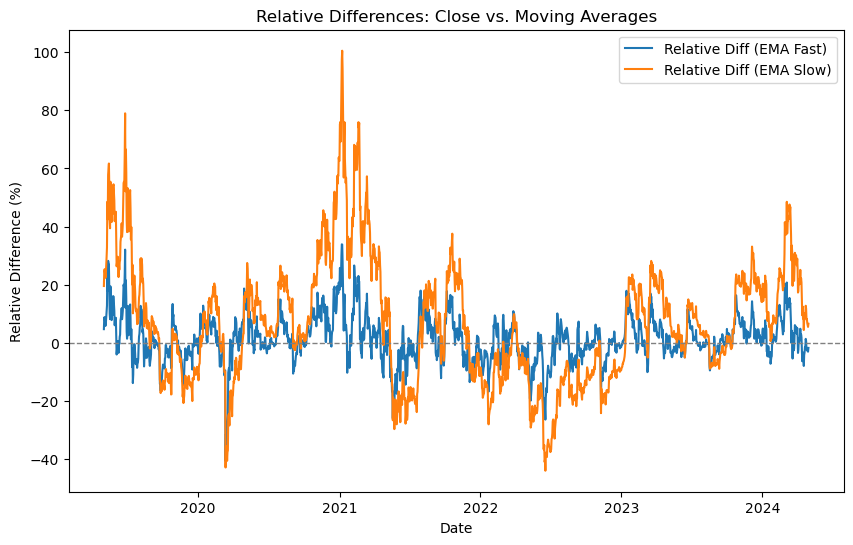

In [28]:
# daily term quantitative signal 

ema_st_d = 20
ema_lt_d = 100

relative_differences_daily(df, ema_st_d, ema_lt_d)

Last Close price: 63841.12 is 57.69% relative to the fast ema and 177.61% relative to the slow ema
Last EMA Fast value (average): 40485.12
Last EMA Slow value (average): 22996.33


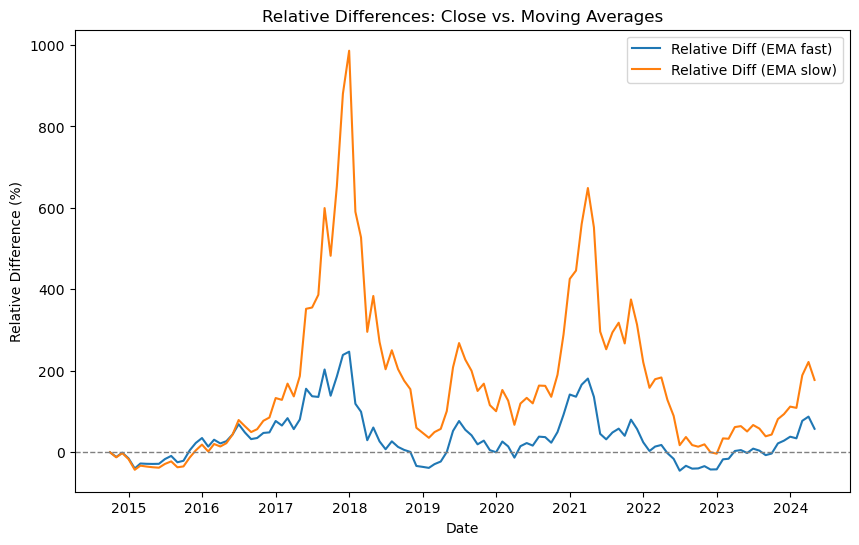

In [29]:
# monthly quantitative signal 

ema_st_m = 20
ema_lt_m = 100

relative_differences_monthly(df, ema_st_m, ema_lt_m)

In [31]:
# parameters for risk and return statistics

rolling_period = 3
observed_periods = 6

Last rolling annualized return: 3.34%


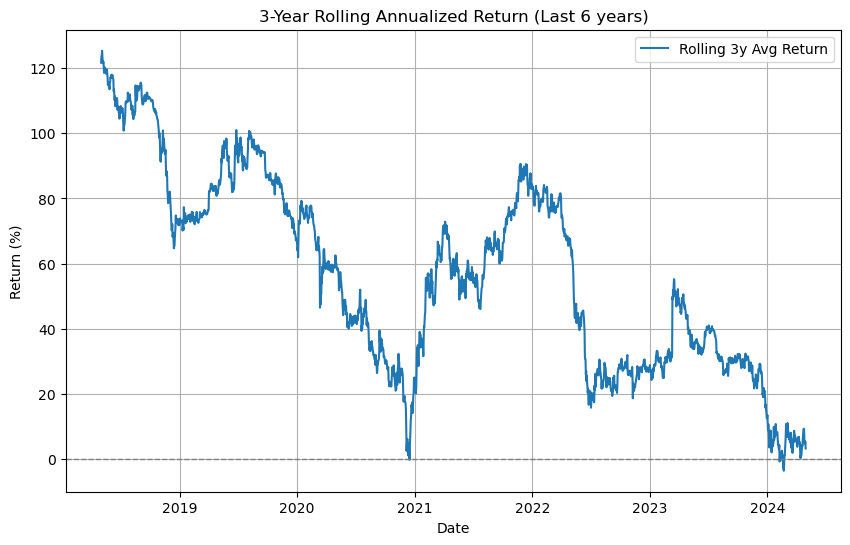

In [32]:
# rolling annualized return

plot_rolling_annualized_return(df, rolling_period, observed_periods)

Last rolling annualized volatility: 59.08%


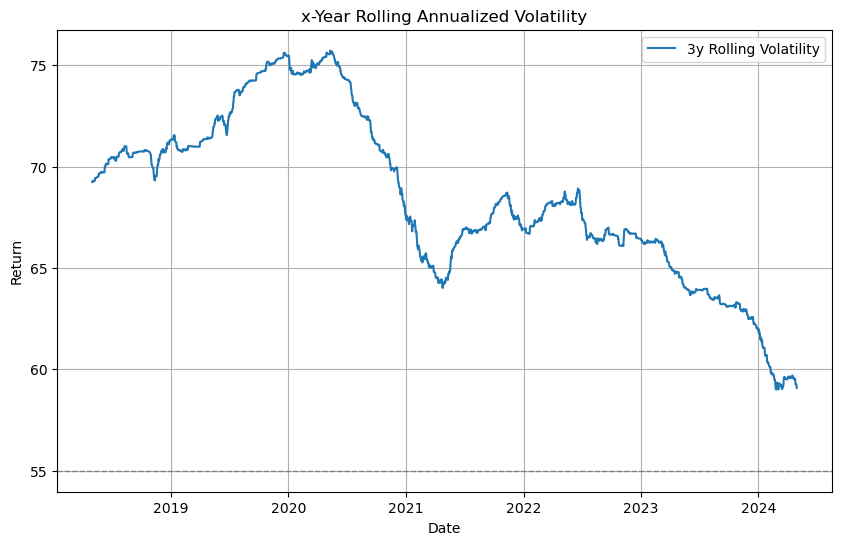

In [33]:
# rolling annualized volatility

plot_rolling_annualized_volatility(df, rolling_period, observed_periods)

Last rolling annualized sharpe: 0.15


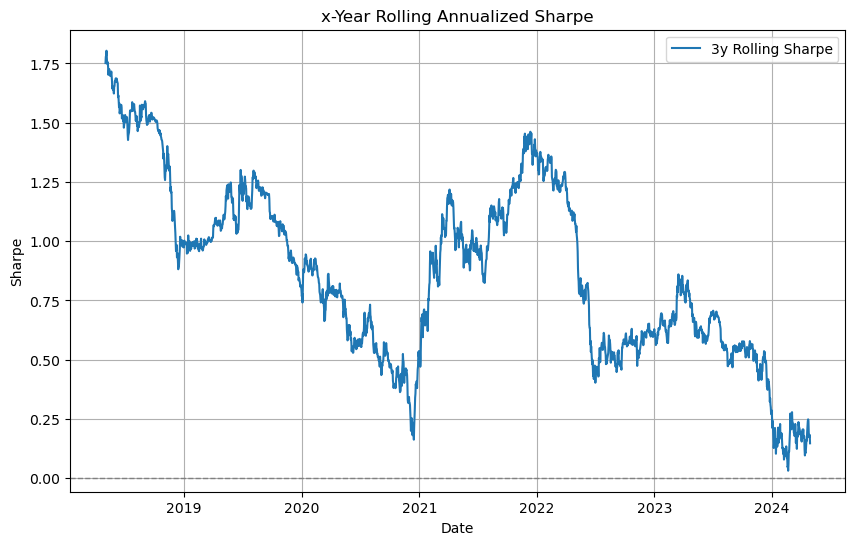

In [34]:
# rolling sharpe ratio

plot_rolling_annualized_sharpe(df, rolling_period, observed_periods)

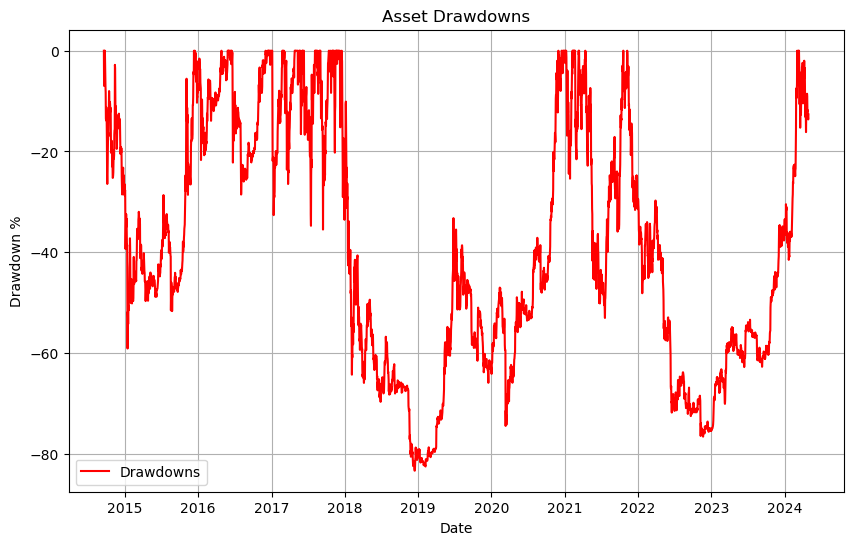

In [35]:
# maximun drawdown

drawdown(df)


## Asset Analysis Within a Total Portfolio

Last rolling correlation: 0.13


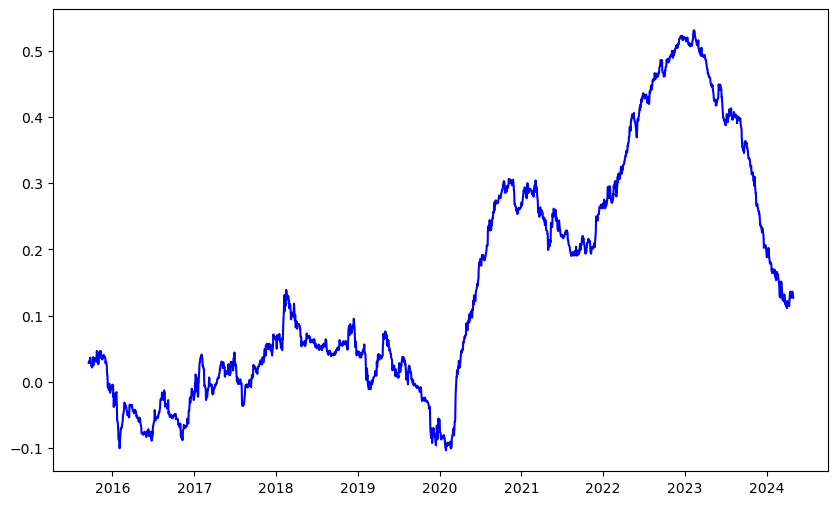

In [36]:
# set date as index 
tmp = data[['date', 'acwi', 'ief', asset]].copy()
tmp = tmp.set_index('date')

# Calculate log returns for all columns
tmp = tmp.dropna()
tmp = np.log(tmp / tmp.shift(1))

# calculate global portfolio returns
weight_stocks = 0.6
tmp['global_port'] = weight_stocks * tmp['acwi'] + (1-weight_stocks) * tmp['ief']
    
# Calculate correlation winsorizing returns
correlation = winsorize_series(tmp['global_port']).rolling(252).corr(winsorize_series(tmp[asset]))

# statistics
last_rolling_correlation = np.array(correlation)[-1].item()
    
# print statistics
print(f"Last rolling correlation: {last_rolling_correlation:.2f}")

# Plot the correlation
plt.figure(figsize=(10, 6))
plt.plot(correlation, linestyle='-', color='b')
plt.show()


## Key Findings
- Bitcoin its becoming more of a traditional asset class showing declining returns and declining volatility relative to its history. 
- Bitcoin risk/return profile measured by sharpe ratio its approaching those of traditional asset classes.
- Bitcoin's correlation with a 60/40 portfolio is low offering diversification benefits, but in times of rising market volatility its diversification benefits may be less obvious.